# Protein Engineering
---
In this Jupyter Notebook we are looking at an example protein engineering workflow. The data used for this example is obtained from a study which used deep mutational scanning to evaluate the ability of the virus SARS-CoV 2 to avoid detection in antigen tests. https://doi.org/10.1016/j.cell.2022.08.010

In this notebook we will be using Large Language Models (LLMs) to predict the mutational effects on the escape score. But first, let's take a look at the structure. The structure was simulated using ESMFold: https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/ESMFold.ipynb#scrollTo=Ky5q4Zto7iXf

In [1]:
import sys
sys.path.append('../')
from analysis import pdb

wt_seq = "MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNTASWFTALTQHGKEDLKFPRGQGVPINTNSSPDDQIGYYRRATRRIRGGDGKMKDLSPRWYFYYLGTGPEAGLPYGANKDGIIWVATEGALNTPKDHIGTRNPANNAAIVLQLPQGTTLPKGFYAEGSRGGSQASSRSSSRSRNSSRNSTPGSSRGTSPARMAGNGGDAALALLLLDRLNQLESKMSGKGQQQQGQTVTKKSAAEASKKPRQKRTATKAYNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTFPPTEPKKDKKKKADETQALPQRQKKQQTVTLLPAADLDDFSKQLQQSMSSADSTQA"
wt_struc = '../example_data/A0A6B9VLF5/A0A6B9VLF5.pdb'

# visualize pdb
view = pdb.show(pdb_str=wt_struc, color='confidence')
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

![text](../example_data/A0A6B9VLF5/ptm0.181_r3_default.png)

As we can see from the structure and the predicted confidence metrics, the protein very likely has a disordered structure. This is consistent with literature. Structure based reasoning is therefore quite difficult when predicting mutational effects. Luckily we have LLMs.

## Mutational Data
---
Next up we are going to take a look at the mutational data, which was obtained from the study. The data consists of 4 columns and 7668 rows. In the first column are indices for each entry, the second column describes the mutations, the third the escape score and the fourth the adjusted p-value for each score:

In [2]:
import pandas as pd

escape_scores = pd.read_csv('../example_data/A0A6B9VLF5//EscapeScores.csv', delimiter=';')
escape_scores

,mutation,score,p_adj
0,S2A,"-0,895337823","3,6488E-154"
1,S2C,"-0,740603214",1E-300
2,S2D,"-0,122452451","5,21669E-22"
3,S2E,"-0,314150629","3,84292E-56"
4,S2F,"0,39614936","0,095880287"
...,...,...,...
7664,A419S,"0,668148405","2,6822E-42"
7665,A419T,"0,284503599",1
7666,A419V,"-0,875444052","3,5202E-219"
7667,A419W,"-0,759712515","9,4364E-152"


## Training Data
---
We are going to use the data to generate a fasta file of the format:

```
>{index}|{id}|{score}
{Sequence}
```

the fasta file can then be used as input for the embed.py script to generate the embeddings needed for the regression model. When creating embeddings remember to use the esm

In [3]:
import re 

fasta = []
for i, mutation in enumerate(escape_scores.mutation.to_list()):
    s = list(wt_seq)
    ind = int(re.findall(r'\d+', mutation)[0]) - 1
    wt, mut = re.findall(r'[A-Z]', mutation)
    score = escape_scores.score.to_list()[i].replace(',','.')
    if wt_seq[ind] == wt:
        s[ind] = mut
        s = "".join(s)
    else:
        print('error in data')
        break
    
    fasta.append(f'>{i}|{mutation}|{score}')
    fasta.append(s)

with open('../example_data/A0A6B9VLF5/A0A6B9VLF5_mut.fasta', 'w') as f:
    for i, line in enumerate(fasta):
        if i < len(fasta) - 1:
            f.writelines(line + '\n')
        else:
            f.writelines(line)

In [4]:
import torch
from io_tools import representations

rep_ids, reps = representations.load('../example_data/representations/A0A6B9VLF5/')

def add_reps(df):
    """
    adds representations to the dataframe
    """
    rs = []
    for uid in df['mutation'].to_list():
        if uid in rep_ids:
            ind = rep_ids.index(uid)
            r = reps[ind]
            rs.append(r)
        else:
            to_drop = df[df['mutation'] == uid].index
            # Drop the row
            df = df.drop(to_drop)
    
    df['representation'] = rs
    return df

escape_scores = add_reps(escape_scores)

In [5]:
escape_scores

,mutation,score,p_adj,representation
0,S2A,"-0,895337823","3,6488E-154","[tensor(-0.3104), tensor(-0.0538), tensor(-0.0..."
1,S2C,"-0,740603214",1E-300,"[tensor(-0.3112), tensor(-0.0514), tensor(-0.0..."
2,S2D,"-0,122452451","5,21669E-22","[tensor(-0.3014), tensor(-0.0465), tensor(-0.0..."
3,S2E,"-0,314150629","3,84292E-56","[tensor(-0.3018), tensor(-0.0441), tensor(-0.0..."
4,S2F,"0,39614936","0,095880287","[tensor(-0.3089), tensor(-0.0442), tensor(-0.0..."
...,...,...,...,...
7664,A419S,"0,668148405","2,6822E-42","[tensor(-0.3082), tensor(-0.0567), tensor(-0.0..."
7665,A419T,"0,284503599",1,"[tensor(-0.3091), tensor(-0.0559), tensor(-0.0..."
7666,A419V,"-0,875444052","3,5202E-219","[tensor(-0.3027), tensor(-0.0553), tensor(-0.0..."
7667,A419W,"-0,759712515","9,4364E-152","[tensor(-0.2982), tensor(-0.0448), tensor(-0.0..."


## Model construction
---
In the following we are going to build machine learning models to predict the effect of the mutations on the escape score of the protein. We will try many different types of models and compare which ones perform best. The best performing model will then be used to design new variants. The models we are going to use are K-neighbors, support vector machines (SVMs), Random Forrests (RF), and Multi-Layer Perceptrons (MLPs). However, before we start modeling, we are going to visualize the variant embeddings using PCA. 

In [6]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


Xs = torch.stack(escape_scores['representation'].to_list(), dim=0).numpy()


Ys = [float(x.replace(',','.')) for x in escape_scores['score'].to_list()]

# normalize Ys between 0 and 1
y_max = max(Ys)
y_min = min(Ys)
Ys = [(x+y_min)/(y_max+y_min) for x in Ys]

train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, Ys, train_size=train_size, random_state=42)
Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

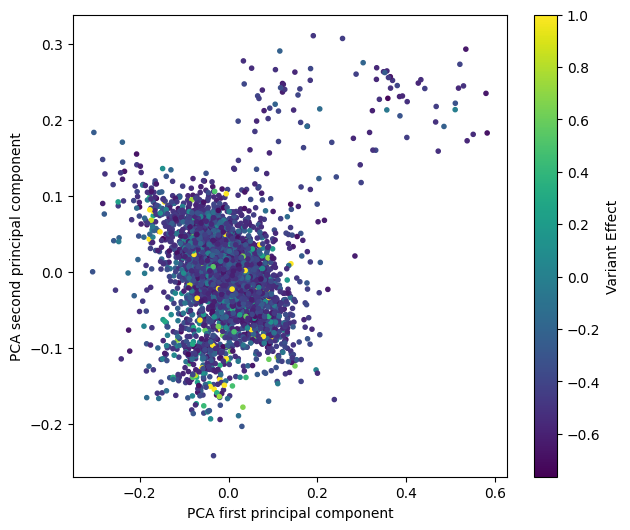

In [7]:
import matplotlib.pyplot as plt

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

## Visualization with TSNE
---
T-distributed Stochastic Neighbor Embedding (T-SNE) is a tool for visualizing high-dimensional data. T-SNE, based on stochastic neighbor embedding, is a nonlinear dimensionality reduction technique to visualize data in a two or three dimensional space. This visualization tool is more useful for visualizing representation spaces.

In [16]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(Xs) 

escape_scores["Ys"] = Ys
escape_scores["comp-1"] = z[:,0]
escape_scores["comp-2"] = z[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7669 samples in 0.002s...
[t-SNE] Computed neighbors for 7669 samples in 1.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7669
[t-SNE] Computed conditional probabilities for sample 2000 / 7669
[t-SNE] Computed conditional probabilities for sample 3000 / 7669
[t-SNE] Computed conditional probabilities for sample 4000 / 7669
[t-SNE] Computed conditional probabilities for sample 5000 / 7669
[t-SNE] Computed conditional probabilities for sample 6000 / 7669
[t-SNE] Computed conditional probabilities for sample 7000 / 7669
[t-SNE] Computed conditional probabilities for sample 7669 / 7669
[t-SNE] Mean sigma: 0.047338
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.160843
[t-SNE] KL divergence after 1000 iterations: 1.771530


[Text(0.5, 1.0, 'Variants T-SNE projection')]

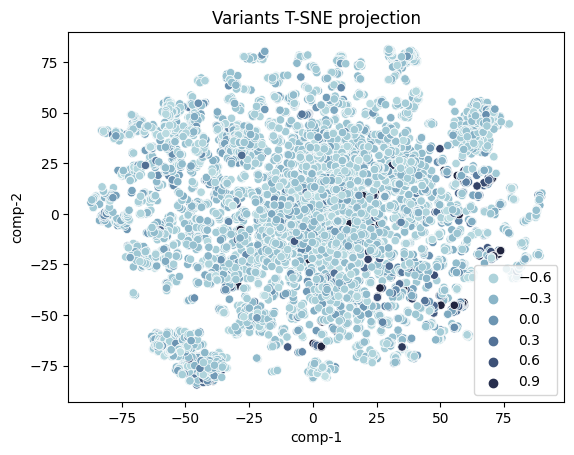

In [24]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.scatterplot(x="comp-1", y="comp-2", hue=escape_scores.Ys.tolist(),
                palette=cmap,
                data=escape_scores).set(title="Variants T-SNE projection") 

## Model

In [8]:
from sklearn.neighbors import KNeighborsRegressor

# Train the kNN classifier
optimal_n = 0
optimal_acc = 0
for n in range(1, 20):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(Xs_train, ys_train)

    # Evaluate the classifier on the test data
    accuracy = knn.score(Xs_test, ys_test)
    if accuracy > optimal_acc:
        optimal_n = n
        optimal_acc = accuracy
        
knn = KNeighborsRegressor(n_neighbors=optimal_n)
knn.fit(Xs_train, ys_train)

# Evaluate the classifier on the test data
accuracy = knn.score(Xs_test, ys_test)        
print("R squared: {:.2f}".format(accuracy))
print("optimal n:", optimal_n)

R squared: 0.26
optimal n: 9


In [9]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Train the SVM classifier
svm = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svm.fit(Xs_train, ys_train)

# Evaluate the classifier on the test data
accuracy = svm.score(Xs_test, ys_test)
print("R squared: {:.2f}".format(accuracy))

R squared: 0.31


In [10]:
from sklearn.ensemble import RandomForestRegressor

# Train the random forest classifier
rf = RandomForestRegressor(max_depth=10, random_state=0)
rf.fit(Xs_train, ys_train)

# Evaluate the classifier on the test data
accuracy = rf.score(Xs_test, ys_test)
print("R squared: {:.2f}".format(accuracy))

R squared: 0.11


In [11]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=42, hidden_layer_sizes=(100, 100),
                       max_iter = 10000, activation = 'relu',
                       solver = 'lbfgs').fit(Xs_train, ys_train)

print("R squared: {:.2f}".format(regr.score(Xs_test, ys_test)))

R squared: 0.06
